In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.animation as animation
from IPython.display import HTML

from laplace_helper import L2_rel_error

In [17]:
nx = 41
ny = 41
L  =  1
H =  1

dx  =  L/(nx-1)
dy=  H/(ny-1)

l1_norm = 1
l1_target = 1e-8

p_i = np.zeros((ny,nx))

x = np.linspace(0,L,nx) 
y = np.linspace(0,H,ny) 


p_i[-2,2:-2]=1/2*(1/2*p_i[-3,2:-2]-dy)     #en y = L
p_i[1,2:-2]= 1/4*p_i[2,2:-2]         #en y=0
p_i[1:-1,1] = 1/4*p_i[1:-1,2]     #en x = 0 (forward 2nd order)
p_i[1:-1,-2] = 1/4*p_i[1:-1,-3]   #en x = l

In [18]:
def L1norm(new, old):
    norm = np.sum(np.abs(new-old))
    return norm



In [24]:
def conjugate_gradient_biharm(p, dx, dy, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = np.zeros((ny,nx)) # residual
    Ad  = np.zeros((ny,nx)) # to store result of matrix multiplication Axd
    
    l1_norm = 1
    iterations = 0
    l2_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    r[2:-2,2:-2]= (1/dx**4)*(-20 *p[2:-2,2:-2]+ (8*(p[2:-2,3:-1] + p[3:-1,2:-2] + p[2:-2,1:-3]+ p[1:-3, 2:-2])\
                          -2*(p[1:-3,3:-1]+p[3:-1,1:-3]+p[3:-1,3:-1]+p[1:-3,1:-3])\
                          -(p[2:-2,4:]+p[4:,2:-2]+p[2:-2,:-4]+p[:-4,2:-2])))
    

    d = r.copy()    #d0=r0 (copie par secu)
    rho = np.sum(r*r)  #multiplication scalaire 
    #matrice A x d
    Ad[2:-2,2:-2]= -(1/dx**4)*(-20*d[2:-2,2:-2] + (8*(d[2:-2,3:-1] + d[3:-1,2:-2] + d[2:-2,1:-3]+ \
                        d[1:-3, 2:-2])+2*(-d[1:-3,3:-1]-d[3:-1,1:-3]-d[3:-1,3:-1]-\
                        d[1:-3,1:-3])+(-d[2:-2,4:]-d[4:,2:-2]-\
                        d[2:-2,:-4]-d[:-4,2:-2])))

    sigma = np.sum(d*Ad)
    #p=border_cond(l, dy)
    # Iterations
    while l1_norm > l2_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        #on les mets parce que: on def les cond avant la boucle, pas besoin de mettre avant le pk, par contre après
        #on en aura besoin

        p[0,:]=p[:,0]=p[-1,:]=p[:,-1]=0   #dirichlet
        #cond de Neumann
        
        p[-2,2:-2]=1/2*(1/2*p[-3,2:-2]-dy)     #en y = L
        p[1,2:-2]= 1/4*p[2,2:-2]         #en y=0
        p[1:-1,1] = 1/4*p[1:-1,2]     #en x = 0 (forward 2nd order)
        p[1:-1,-2] = 1/4*p[1:-1,-3]   #en x = l
        
        rhop1 = np.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad[2:-2,2:-2]= -(1/dx**4)*(-20*d[2:-2,2:-2] + (8*(d[2:-2,3:-1] + d[3:-1,2:-2] + d[2:-2,1:-3]+ \
                        d[1:-3, 2:-2])+2*(-d[1:-3,3:-1]-d[3:-1,1:-3]-d[3:-1,3:-1]-\
                        d[1:-3,1:-3])+(-d[2:-2,4:]-d[4:,2:-2]-\
                        d[2:-2,:-4]-d[:-4,2:-2])))
       # Ad[1:-1,1:-1] = -4*d[1:-1,1:-1] + d[1:-1,2:] + d[1:-1,:-2] + \
         #   d[2:, 1:-1] + d[:-2, 1:-1]
        sigma = np.sum(d*Ad)
        

        #p=border_cond(l, dy)
        # BCs are automatically enforced
        #p=border_cond(l, delta_x)
        
        l1_norm = L1norm(pk,p)
        iterations += 1
        l2_conv.append(l1_norm)
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l2_conv     


In [25]:
p, l2_conv = conjugate_gradient_biharm(p_i.copy(), dx, dy, l1_target)


Number of CG iterations: 648


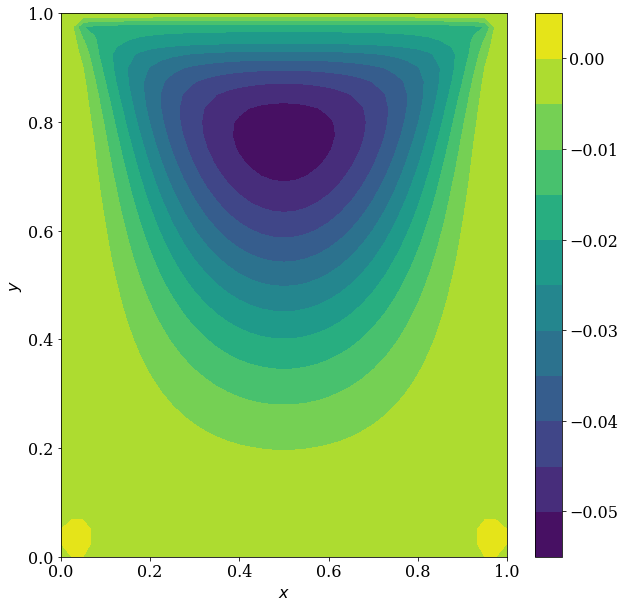

In [22]:
pyplot.figure(figsize=(10,10))
pyplot.contourf(x,y,p,10,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

In [23]:
print(p[8,24],p[16,24],p[24,24],p[32,24])

-0.004702625222216156 -0.01819644541556883 -0.038475318220838266 -0.050566282269552114
